# AlexNet

### 1. 모델 생성

In [1]:
import torch
import torch.nn as nn

IMAGE_SIZE = 227

class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

    dummy_input = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    dummy_output = self.features(dummy_input)
    flatten_dim = dummy_output.view(1, -1).shape[1]

    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(flatten_dim, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),

        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

### 2. 커스텀 Dataset 클래스 생성

In [2]:
from torch.utils.data import Dataset
import numpy as np
import cv2
from sklearn.utils import shuffle

BATCH_SIZE = 64

class CIFAR10Dataset(Dataset):
  def __init__(self, images, labels=None, image_size=IMAGE_SIZE, augmentor=None, preprocess_function=None, shuffle_data=False):
    self.images = images
    self.labels = labels
    self.image_size = image_size
    self.augmentor = augmentor
    self.preprocess_function = preprocess_function

    if shuffle_data and labels is not None:
      self.images, self.labels = shuffle(self.images, self.labels)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx] if self.labels is not None else None

    if self.augmentor is not None:
      image = self.augmentor(image)['image']

    image = cv2.resize(image, (self.image_size, self.image_size))

    if self.preprocess_function is not None:
      image = self.preprocess_function(image)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)

    if label is not None:
      return image, label
    else:
      return image

### 3. 데이터 로드

In [3]:
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn.functional as F

train_data = CIFAR10(root='./', train=True, download=True)
test_data = CIFAR10(root='./', train=False, download=True)

train_images = np.array(train_data.data)
train_labels = np.array(train_data.targets).reshape(-1, 1)
test_images = np.array(test_data.data)
test_labels = np.array(test_data.targets).reshape(-1, 1)

tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

tr_labels = F.one_hot(torch.tensor(tr_labels.squeeze()), num_classes=10).numpy()
val_labels = F.one_hot(torch.tensor(val_labels.squeeze()), num_classes=10).numpy()
test_labels = F.one_hot(torch.tensor(test_labels.squeeze()), num_classes=10).numpy()

100%|██████████| 170M/170M [00:05<00:00, 31.9MB/s]


In [4]:
def pre_func(image):
  return image / 255.0

In [5]:
from torch.utils.data import DataLoader

tr_dataset = CIFAR10Dataset(tr_images, tr_labels, preprocess_function=pre_func, shuffle_data=True)
val_dataset = CIFAR10Dataset(val_images, val_labels, preprocess_function=pre_func)
test_dataset = CIFAR10Dataset(test_images, test_labels, preprocess_function=pre_func)

tr_loader = DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 4. 모델 학습

In [6]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = AlexNet(num_classes=10)
model = model.cuda() if torch.cuda.is_available() else model
device = next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters())
scheduler = ReduceLROnPlateau(optim, mode='min', patience=5, factor=0.5)

In [7]:
class EarlyStopping:
  def __init__(self, patience=10, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_loss = float('inf')
    self.best_model = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if val_loss < self.best_loss:
      self.best_loss = val_loss
      self.best_model = model.state_dict()
      self.counter = 0
    else:
      self.counter += 1
      if self.verbose:
        print(f"조기종료 Counter: {self.counter}/{self.patience}")
      if self.counter >= self.patience:
        self.early_stop = True

early_stopping = EarlyStopping(patience=10, verbose=True)

In [8]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

epochs = 30

for epoch in range(epochs):
  model.train()
  train_loss = 0.0
  train_total = 0
  train_correct = 0

  for images, labels in tr_loader:
    images, labels = images.to(device), labels.to(device)
    labels = torch.argmax(labels, dim=1)

    optim.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optim.step()

    train_loss += loss.detach().cpu().item()
    _, pred = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += (pred == labels).sum().detach().cpu().item()

  model.eval()
  val_loss = 0.0
  val_total = 0
  val_correct = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      labels = torch.argmax(labels, dim=1)
      outputs = model(images)
      loss = criterion(outputs, labels)

      val_loss += loss.detach().cpu().item()
      _, pred = torch.max(outputs, 1)
      val_total += labels.size(0)
      val_correct += (pred == labels).sum().detach().cpu().item()

  train_loss /= len(tr_loader)
  val_loss /= len(val_loader)
  train_acc = train_correct / train_total
  val_acc = val_correct / val_total

  history["train_loss"].append(train_loss)
  history["train_acc"].append(train_acc)
  history["val_loss"].append(val_loss)
  history["val_acc"].append(val_acc)

  if (epoch + 1) % 5 == 0:
    print(f"Epoch [{epoch + 1}/{epochs}] {train_acc=:.4f} {train_loss=:.4f} {val_acc=:.4f} {val_loss=:.4f}")

  scheduler.step(val_loss)
  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("조기 종료!!!!!")
    break

Epoch [5/30] train_acc=0.5451 train_loss=1.2808 val_acc=0.5687 val_loss=1.2323
조기종료 Counter: 1/10
Epoch [10/30] train_acc=0.7692 train_loss=0.6750 val_acc=0.7711 val_loss=0.6681
조기종료 Counter: 1/10
조기종료 Counter: 1/10
조기종료 Counter: 2/10
Epoch [15/30] train_acc=0.8764 train_loss=0.3630 val_acc=0.8023 val_loss=0.6040
조기종료 Counter: 1/10
조기종료 Counter: 1/10
Epoch [20/30] train_acc=0.9323 train_loss=0.2050 val_acc=0.8053 val_loss=0.6838
조기종료 Counter: 2/10
조기종료 Counter: 3/10
조기종료 Counter: 4/10
조기종료 Counter: 5/10
조기종료 Counter: 6/10
Epoch [25/30] train_acc=0.9732 train_loss=0.0812 val_acc=0.8446 val_loss=0.6876
조기종료 Counter: 7/10
조기종료 Counter: 8/10
조기종료 Counter: 9/10
조기종료 Counter: 10/10
조기 종료!!!!!


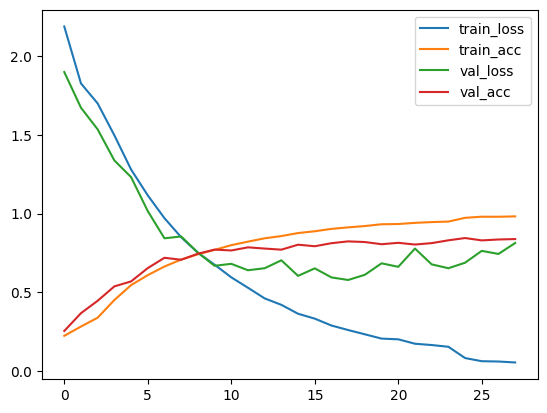

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(history)
df.plot()
plt.show()

In [12]:
model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    labels = torch.argmax(labels, dim=1)
    outputs = model(images)
    loss = criterion(outputs, labels)

    test_loss += loss.detach().cpu().item()
    _, pred = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (pred == labels).sum().detach().cpu().item()

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"Test 결과: {test_acc=:.4f} {test_loss=:.4f}")

Test 결과: test_acc=0.8311 test_loss=0.8964
